Import all the libraries I will need for data handling, visualization and modeling

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay


Load the cleaned diabetes dataset and check its shape

In [11]:
dataset_path="/content/diabetes_cleaned.csv"
df=pd.read_csv(dataset_path)

print("Shape:",df.shape)

Shape: (229474, 22)


Preview the first few rows of the dataset

In [12]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,...,1,0,5.0,18.0,15.0,1,0,9.0,4.0,3.0
1,0,0,0,0,25.0,1,0,0,1,0,...,0,1,3.0,0.0,0.0,0,0,7.0,6.0,1.0
2,0,1,1,1,28.0,0,0,0,0,1,...,1,1,5.0,30.0,30.0,1,0,9.0,4.0,8.0
3,0,1,0,1,27.0,0,0,0,1,1,...,1,0,2.0,0.0,0.0,0,0,11.0,3.0,6.0
4,0,1,1,1,24.0,0,0,0,1,1,...,1,0,2.0,3.0,0.0,0,0,11.0,5.0,4.0


Visualise class distribution and feature correlations

/tmp/ipython-input-3494114892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x='Diabetes_binary',palette="coolwarm")


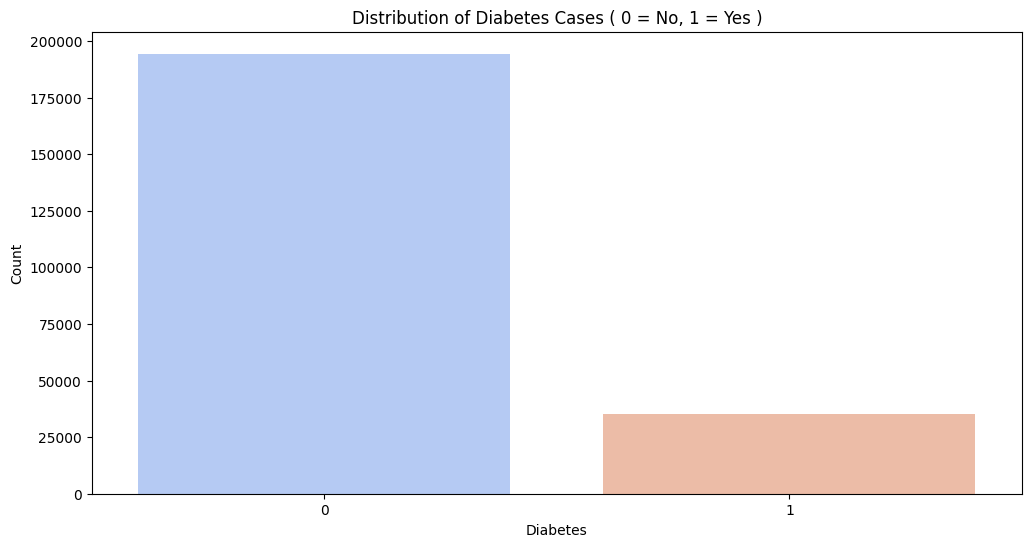

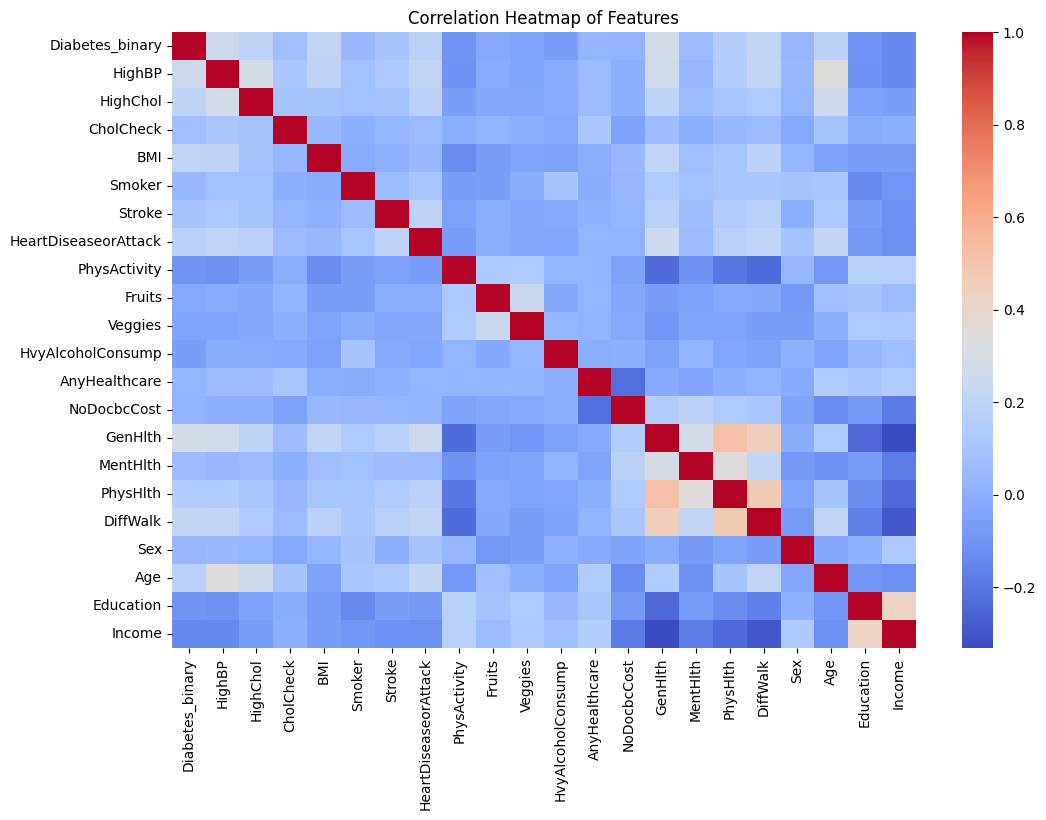

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(data=df,x='Diabetes_binary',palette="coolwarm")
plt.title("Distribution of Diabetes Cases ( 0 = No, 1 = Yes )")
plt.xlabel("Diabetes")
plt.ylabel("Count")
plt.show()
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),cmap="coolwarm",annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()


Split features and target into training and test sets

In [14]:
X = df.drop("Diabetes_binary",axis=1)
y = df["Diabetes_binary"]

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)


Set up preprocessing pipelines with different scaling methods

In [15]:
numerical_cols=X.columns.tolist()

preprocessor_no_scale = ColumnTransformer(
    transformers=[('num',SimpleImputer(strategy='mean'),numerical_cols)]
)

preprocessor_std = ColumnTransformer(
    transformers=[('num',Pipeline([
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler',StandardScaler())
    ]), numerical_cols)]
)

preprocessor_norm = ColumnTransformer(
    transformers=[('num',Pipeline([
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler',MinMaxScaler())
    ]), numerical_cols)]
)

Define logistic regression models with different scaling

In [16]:
models = {
    "No Scaling": Pipeline([
        ('preprocessor', preprocessor_no_scale),
        ('classifier', LogisticRegression(max_iter=5000, solver='lbfgs'))
    ]),
    "Standardization": Pipeline([
        ('preprocessor', preprocessor_std),
        ('classifier', LogisticRegression(max_iter=5000, solver='lbfgs'))
    ]),
    "Normalization": Pipeline([
        ('preprocessor', preprocessor_norm),
        ('classifier', LogisticRegression(max_iter=5000, solver='lbfgs'))
    ]),
    "Lasso (L1)": Pipeline([
        ('preprocessor', preprocessor_std),
        ('classifier', LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000))
    ]),
    "Ridge (L2)": Pipeline([
        ('preprocessor', preprocessor_std),
        ('classifier', LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=5000))
    ])
}


Train each model and compare their performance metrics

In [17]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "Log Loss": log_loss(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
print(results_df)

             Model  Accuracy   ROC-AUC  Log Loss
0       No Scaling  0.850528  0.810199  0.344196
1  Standardization  0.850528  0.810189  0.344192
2    Normalization  0.850507  0.810090  0.344200
3       Lasso (L1)  0.850550  0.810186  0.344194
4       Ridge (L2)  0.850528  0.810189  0.344192


Evaluate the best model in detail with classification report

In [18]:
best_model = models["Ridge (L2)"]
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test,y_pred_best))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     38876
           1       0.54      0.15      0.24      7019

    accuracy                           0.85     45895
   macro avg       0.70      0.57      0.58     45895
weighted avg       0.81      0.85      0.81     45895



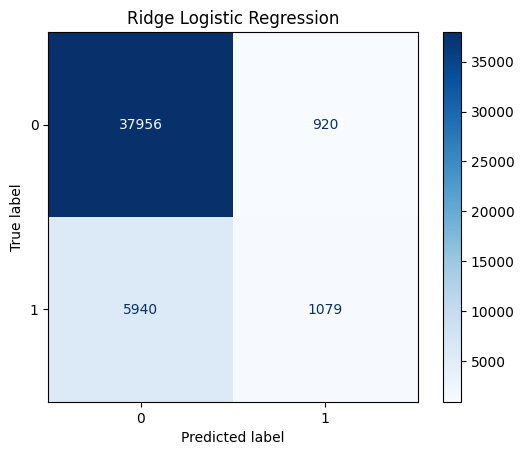

In [19]:
cm = confusion_matrix(y_test,y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Ridge Logistic Regression")
plt.show()


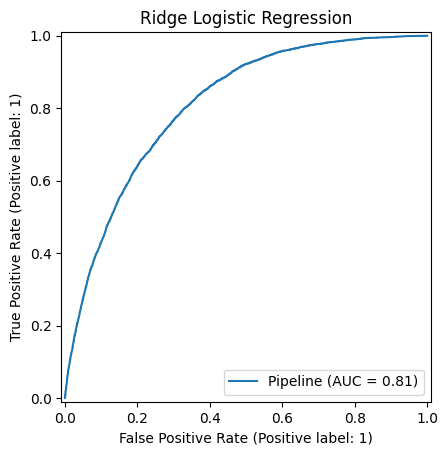

In [20]:
RocCurveDisplay.from_estimator(best_model,X_test,y_test)
plt.title("Ridge Logistic Regression")
plt.show()


Inspect feature importance using L1 regularization (Lasso)

In [22]:
lasso_model = models["Lasso (L1)"]
coef = lasso_model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coef
})
print("Non-zero coefficients:", (coef != 0).sum())
feature_importance.sort_values(by="Coefficient",key=abs,ascending=False).head(10)


Non-zero coefficients: 21


,Feature,Coefficient
13,GenHlth,0.532930
3,BMI,0.396663
18,Age,0.372966
0,HighBP,0.366889
1,HighChol,0.279394
2,CholCheck,0.251052
10,HvyAlcoholConsump,-0.190948
17,Sex,0.130080
20,Income,-0.092903
6,HeartDiseaseorAttack,0.065298
